<a href="https://colab.research.google.com/github/jpcib/met4/blob/main/lomapa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/colabnoteb")

In [ ]:
% pip install geopandas
% pip install fiona
% pip install shapely
% pip install pyproj
% pip install pygeos
% pip install contextily
% pip install mapclassify


In [ ]:
import pandas as pd, matplotlib.pyplot as plt, geopandas as gpd, contextily as ctx, numpy as np, mapclassify.classifiers as classifiers, pygeos as pg

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [ ]:
#cargamos archivo de radios censales 
radios_caba = gpd.read_file(
    "Codgeo_CABA_con_datos/cabaxrdatos.shp", header=0
)
#radios_caba.count()
#type(radios_caba.columns)
#radios_caba.dtypes

In [ ]:
#agregamos columnas de centroides y densidad poblacional 
radios_caba.reset_index()
#unimos tablas de  dpto, frac y radio para usarlas como key 
radios_caba["ID_GEO"] = radios_caba["DEPTO"] + radios_caba["FRAC"] + radios_caba["RADIO"]
#radios_caba.head

In [ ]:
#Cargamos csv datos redatam y unimos columnas de id dpto frac y radio
full_redatam = pd.read_csv("censo_total.csv",dtype={"ID_GEO":str})

#unimos shp censo con datos de nbi, etc de full redatam
x = radios_caba
y = full_redatam
df_censo = pd.merge(x,y,on="ID_GEO", how="inner")
#eliminamos innecesarias
df_censo = df_censo.drop(['PERIMETER','PAIS0210_','PAIS0210_I','PROV','DEPTO','FRAC','RADIO','TIPO','VARONES','MUJERES','HOGARES','VIV_PART','VIV_PART_H','Unnamed: 0','DPTO_REF_ID','PROV_REF_ID','NOMDPTO','FRAC_REF_ID','RADIO_REF_ID','PERSONA_REF_ID','HOGAR_REF_ID','VIVIENDA_REF_ID'],axis=1)
#df_censo.head()


In [ ]:
#agrupación de población por radio, y cantidad de población
censo_agrup1 = ( df_censo
    .groupby(['ID_GEO'], as_index=False)
    .agg({
        'TOT_POB':'count'
        })
)

#agrupar por radio y nivel educativo
#cantidad de población segun nivel educativo y radio
censo_agrup2 = ( df_censo
    .groupby(['ID_GEO','P09'], as_index=False)
    .agg({
        'TOT_POB':'count'
        })
)
#Filtramos nivel universitario
censo_agrup2 = censo_agrup2[(censo_agrup2.P09==7)]

censo_agrup3 = pd.merge(censo_agrup1, censo_agrup2, on='ID_GEO', how='outer')
censo = pd.merge(radios_caba, censo_agrup3, on='ID_GEO', how='inner')
#censo.head()

#Hasta aca fue armado de ***censo***
##Abajo comienza armado de ***elecciones***

In [ ]:
#Cargamos archivo rosetta y creamos variable circuito con los ultimos caracteres de la columna codigo circuito 2017
rosetta = pd.read_csv('rosetta.csv', dtype='str')
rosetta['circuito'] = rosetta.CODIGO_CIRCUITO_2017.apply(lambda x: x[7:11])
#Cargamos archivo de circuitos electorales
elecciones_circuito = gpd.read_file(
      "resultados_shp/CABA.shp", Header= 0, dtype={'CODIGO_CIRCUITO': str}).to_crs('EPSG:22183')
datos_agrup = pd.read_csv("datos_agrup.csv", header=0, dtype={'CODIGO_MESA':str, 'CODIGO_CATEGORIA':str})
datos_agrup = datos_agrup[ datos_agrup.CODIGO_CATEGORIA.isin(['000100000000000'])]


In [ ]:
datos_agruplavagna = datos_agrup[ datos_agrup.CODIGO_CATEGORIA.isin(['000100000000000']) & datos_agrup.CODIGO_AGRUPACION.isin(['137'])]
datos_agruplavagna = pd.merge(datos_agruplavagna,rosetta, left_on=['CODIGO_MESA'], right_on=['CODIGO_MESA_2019'], how='inner')
#datos_agruplavagna.head()

In [ ]:
datosagrup_rosetta = pd.merge(datos_agrup,rosetta, left_on=['CODIGO_MESA'], right_on=['CODIGO_MESA_2019'], how='inner')
#datosagrup_rosetta.head()

In [56]:
agrup_total = ( datosagrup_rosetta
    .groupby(['circuito'], as_index=False)
    .agg({
        'VOTOS_AGRUPACION':'sum'
        })
)
agrup_lavagna = ( datos_agruplavagna
    .groupby(['circuito'], as_index=False)
    .agg({
        'VOTOS_AGRUPACION':'sum'
        })
)
agrup_todo = pd.merge(agrup_lavagna,agrup_total,on='circuito', how='inner')
#agrup_todo.head()

In [57]:
resultados_circuitos = pd.merge(elecciones_circuito,agrup_todo, on='circuito', how= 'outer')
#resultados_circuitos.head()

#Acá termina el armado de datos de circuitos electorales
##vamos abajo con la tabla intermedia

In [58]:
censo['geometry'] = censo.centroid
censo.head()
#out = gpd.sjoin(censo, resultados_circuitos[['geometry','circuito','porc_lavagna']], op="within", how="right")
out = gpd.sjoin(censo, resultados_circuitos[['geometry','circuito']], op="within", how="inner")
out.circuito[~out.circuito.duplicated()]

0       0141
2       0134
11      0133
18      0135
25      0136
        ... 
3285    0087
3380    0090
3382    0097
3422    0089
3523    0088
Name: circuito, Length: 167, dtype: object

In [59]:
inter = out.groupby(['circuito'], as_index=False).agg({
        'TOT_POB_y':'sum',
        'TOT_POB':'sum'
        })
inter.shape

(167, 3)

In [60]:
outer = pd.merge(resultados_circuitos,inter, on='circuito', how='inner')
outer['porc_univ'] = ((outer.TOT_POB_y/outer.TOT_POB)*100)
outer.head()

,distrito,provincia,departamen,cabecera,circuito,indec_p,indec_d,geometry,VOTOS_AGRUPACION_x,VOTOS_AGRUPACION_y,TOT_POB_y,TOT_POB,porc_univ
0,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0003,02,001,"POLYGON Z ((4201850.075 6145619.076 0.000, 420...",107,1755,805.0,3584.0,22.460938
1,01,Ciudad Autónoma de Buenos Aires,Comuna 4,Comuna 4,0045,02,004,"POLYGON Z ((4197341.173 6140168.922 0.000, 419...",349,5354,889.0,7956.0,11.173957
2,01,Ciudad Autónoma de Buenos Aires,Comuna 3,Comuna 3,0037,02,003,"POLYGON Z ((4197631.776 6143302.577 0.000, 419...",695,8264,2836.0,12234.0,23.181298
3,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0018,02,001,"POLYGON Z ((4199530.990 6142769.262 0.000, 419...",405,4918,1326.0,9438.0,14.049587
4,01,Ciudad Autónoma de Buenos Aires,Comuna 13,Comuna 13,0141,02,013,"POLYGON Z ((4195988.000 6151207.466 0.000, 419...",823,11241,5061.0,14098.0,35.898709


#GRAFICOS

In [48]:
outerord = outer.sort_values(by='indec_d')
outerord.head()

,distrito,provincia,departamen,cabecera,circuito,indec_p,indec_d,geometry,VOTOS_AGRUPACION_x,VOTOS_AGRUPACION_y,porc_lavagna,TOT_POB_y,TOT_POB,porc_univ
0,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0003,02,001,"POLYGON Z ((4201850.075 6145619.076 0.000, 420...",107,1755,6.096866,805.0,3584.0,22.460938
21,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0010,02,001,"POLYGON Z ((4199093.725 6145360.163 0.000, 419...",648,8189,7.913054,3041.0,8110.0,37.496917
20,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0009,02,001,"POLYGON Z ((4199611.565 6145349.496 0.000, 419...",521,7313,7.124299,3531.0,9296.0,37.984079
19,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0008,02,001,"POLYGON Z ((4200345.699 6145880.421 0.000, 420...",357,5738,6.221680,4043.0,9026.0,44.792821
18,01,Ciudad Autónoma de Buenos Aires,Comuna 1,Comuna 1,0007,02,001,"POLYGON Z ((4199613.690 6145349.446 0.000, 419...",284,5335,5.323336,3732.0,8517.0,43.818246


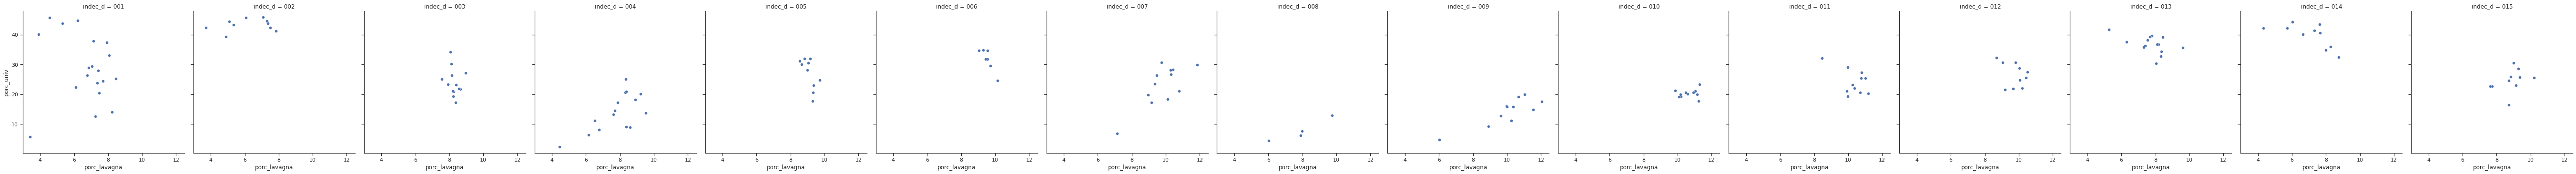

In [50]:

# importing the library 
import seaborn as sns 
  
# selecting style 
sns.set(style ="ticks") 
  
# reading the dataset 

  
sns.relplot(x="porc_lavagna", 
            y="porc_univ",
            col="indec_d",
            data=outerord) 


#MAPAS

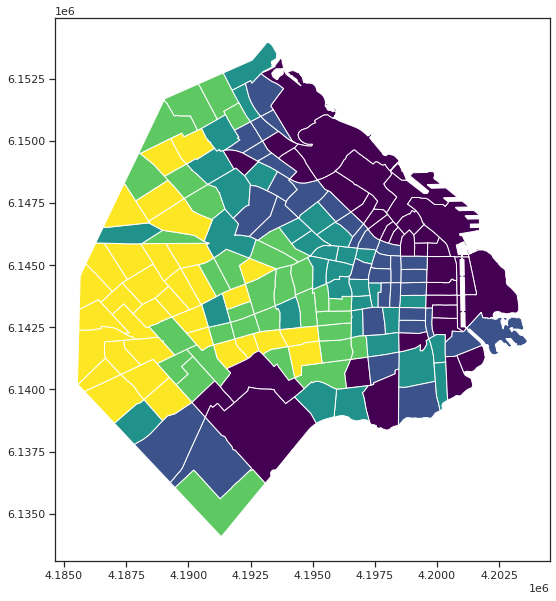

In [54]:
outer.plot(column='porc_lavagna', scheme='quantiles', cmap='viridis', figsize=(10,10))
plt.title('2020 Jan-May Confirmed Case Amount in Different Countries',fontsize=25)

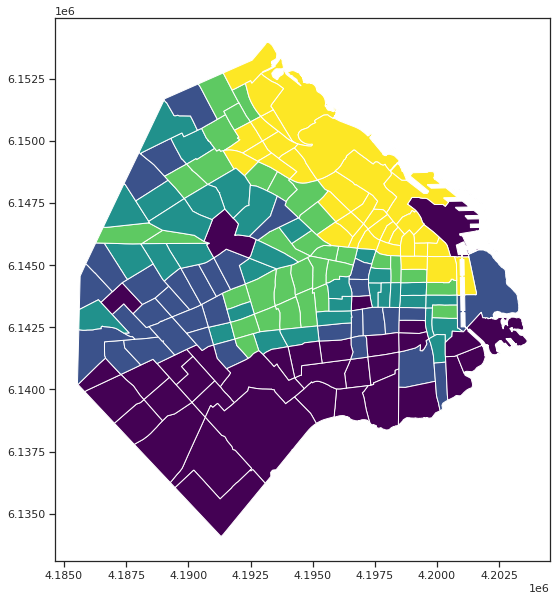

In [55]:
outer.plot(column='porc_univ', scheme='quantiles', cmap='viridis', figsize=(10,10))


In [ ]:
aux = df_censo.centroid
base = radios_caba.plot( figsize=(10, 10), color='None', edgecolor='black')
aux.plot(ax=base, marker='o', color='red', markersize=5)

In [ ]:
#cargamos los datasets del censo 2010  ##### Con columnas seleccionadas para mapas de circuitos/radios #####
dpto = pd.read_csv("dpto.csv",dtype={'IDDPTO':str})
frac = pd.read_csv("frac.csv",dtype={'IDFRAC':str})
radio = pd.read_csv("radio.csv", dtype={'IDRADIO':str})
vivienda = pd.read_csv("vivienda.csv", usecols=[0,1]) #ninguna
hogar = pd.read_csv("hogar.csv", usecols=[0,1,22]) #algunbi
persona = pd.read_csv("persona.csv",usecols=[0,1,4,12,14]) #p03,p09,condact

In [ ]:
totales_caba = pd.read_csv("datos_agrup.csv",
                           header=0,
                           dtype={'VOTOS_AGRUPACION':int, 'CODIGO_CATEGORIA': str,'CODIGO_DISTRITO': str,
                                  'CODIGO_SECCION':str,'CODIGO_AGRUPACION':str})
#seleccionamos segun codigo categoria (presidente y vice)y partido (consenso federal)
totales_caba = totales_caba.loc[ totales_caba.CODIGO_CATEGORIA.isin(['000100000000000']) & totales_caba.CODIGO_AGRUPACION.isin(['137'])] 

totales_caba.value_counts('CODIGO_CIRCUITO')

CODIGO_CIRCUITO
1008000089    137
1008000090    134
1006000071     90
1008000087     89
1007000086     85
             ... 
1004000045     21
1004000046     19
1012000131     17
1001000014     15
1001000003     14
Length: 166, dtype: int64

In [ ]:
circuitos_radios.columns

Index(['distrito', 'provincia', 'departamen', 'cabecera', 'circuito',
       'indec_p', 'indec_d', 'geometry', 'index_right', 'AREA', 'PERIMETER',
       'PAIS0210_', 'PAIS0210_I', 'PROV', 'DEPTO', 'FRAC', 'RADIO', 'TIPO',
       'LINK', 'VARONES', 'MUJERES', 'TOT_POB', 'HOGARES', 'VIV_PART',
       'VIV_PART_H'],
      dtype='object')

In [ ]:
Fraccion 
-
Radio

RADIO_REF_ID - PK
VIVIENDA_REF_ID - SK
RADIO_ID
...

vivienda

VIVIENDA_REF_ID - PK
HOGAR_REF_ID - SK
V01
V02
...

Hogar

HOGAR_REF_ID - PK
PERSONA_REF_ID - SK
H02
H05
PROP 
...

Persona

PERSONA_REF_ID - PK
P03
CONDACT
...
